### This notebook demonstrates the alternative DCTR fitting method applied on Lund jet datasets

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
# standard library imports
from __future__ import absolute_import, division, print_function

import keras

# standard numerical library imports
import numpy as np
import scipy as sp

# energyflow imports
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split, remap_pids, to_categorical

import matplotlib.pyplot as plt

import keras.backend as K
import pickle
import matplotlib.pyplot as plt

Using TensorFlow backend.
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/root/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/dtype

In [3]:
import tensorflow as tf

In [4]:
from IPython.display import Image, display

## Utilities

In [5]:
# normalize pT and center (y, phi)
def normalize(x):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

In [6]:
def preprocess_data(X):
    for x in X:
        normalize(x)
    
    # Remap PIDs to unique values in range [0,1]
    remap_pids(X, pid_i=3)
    return X

In [7]:
# network architecture parameters
Phi_sizes = (100,100, 128)
F_sizes = (100,100, 100)

dctr = PFN(input_dim=7, 
           Phi_sizes=Phi_sizes, F_sizes=F_sizes,
           summary=True)

#load model from saved file
dctr.model.load_weights('./saved_models/DCTR_ee_dijets_1D_aLund.h5')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 7)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    800         input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_1[0][0]               
__________________________________________________________________________________________________
activation

In [8]:
test_dataset_0 = np.load('test1D_default.npz')
test_dataset_1 = np.load('test1D_aLund.npz')

In [9]:
dctr

## Load Data

In [10]:
X_default = preprocess_data(test_dataset_0['jet'][:,:,:4])
X_unknown = preprocess_data(test_dataset_1['jet'][:,:,:4])

Y_default = np.zeros_like(X_unknown[:,0,0])
Y_unknown = np.ones_like(X_unknown[:,0,0])

In [11]:
X_fit = np.concatenate((X_default, X_unknown), axis = 0)

Y_fit = np.concatenate((Y_default, Y_unknown), axis = 0)
Y_fit = to_categorical(Y_fit, num_classes=2)

In [12]:
X_fit, _, Y_fit, _ = data_split(X_fit, Y_fit, test=0, shuffle=True)

# Fitting

## Loss Curve Model

In [13]:
class AddParams2Input(keras.layers.Layer):
    """ Custom layer for tuning with DCTR: 
    Arguments:
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Usage: 
    Let X_dim be the input dimension of each particle to a PFN model, and n_MC_params be the number of MC parameters. 
    Defines a Layer that takes in an array of dimension 
    (batch_size, padded_multiplicity, X_dim - n_MC_params)
    This layer appends each particle by the default_MC_params and makes then trainable or non-trainable based on trainable_MC_params
    """
    
    def __init__(self, n_MC_params, default_MC_params, trainable_MC_params):
        super(AddParams2Input, self).__init__()
        # Definitions
        self.n_MC_params = n_MC_params
        self.MC_params = default_MC_params
        self.trainable_MC_params = trainable_MC_params

    
    def build(self, input_shape):
        # Convert input MC parameters to weights and make then trainable or non-trainable
        for i in range(self.n_MC_params):
            self.MC_params[i] = self.add_weight(name='MC_param_{}'.format(i), 
                                                shape=(1, 1),
                                                initializer=keras.initializers.Constant(self.MC_params[i]),
                                                trainable=self.trainable_MC_params[i])
            
        self.MC_params = keras.backend.tf.concat(self.MC_params, axis = -1)
        super(AddParams2Input, self).build(input_shape)
    
    def call(self, input):
        # Add MC params to each input particle (but not to the padded rows)
        concat_input_and_params = keras.backend.tf.where(keras.backend.abs(input[...,0])>0,
                                                         self.MC_params*keras.backend.ones_like(input[...,0:self.n_MC_params]),
                                                         keras.backend.zeros_like(input[...,0:self.n_MC_params]))
        return keras.backend.concatenate([input, concat_input_and_params], -1)
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1]+self.n_MC_params)

In [14]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import variables as variables_module

def _backtrack_identity(tensor):
    while tensor.op.type == 'Identity':
        tensor = tensor.op.inputs[0]
    return tensor

def my_loss_wrapper():
    def my_loss(y_true,y_pred):
        target = y_true
        output = y_pred
        axis = -1
        from_logits = False
        target.shape.assert_is_compatible_with(output.shape)
        if from_logits:
            return nn.softmax_cross_entropy_with_logits_v2(
                labels=target, logits=output, axis=axis)

        if not isinstance(output, (ops.EagerTensor, variables_module.Variable)):
            output = _backtrack_identity(output)
            if output.op.type == 'Softmax':
                # When softmax activation function is used for output operation, we
                # use logits from the softmax function directly to compute loss in order
                # to prevent collapsing zero when training.
                # See b/117284466
                assert len(output.op.inputs) == 1
                output = output.op.inputs[0]
                return nn.softmax_cross_entropy_with_logits_v2(
                  labels=target, logits=output)

        # scale preds so that the class probas of each sample sum to 1
        output = output / math_ops.reduce_sum(output, axis, True)
        # Compute cross entropy from probabilities.
        epsilon_ = _constant_to_tensor(epsilon(), output.dtype.base_dtype)
        output = clip_ops.clip_by_value(output, epsilon_, 1. - epsilon_)
        return -math_ops.reduce_sum(target * math_ops.log(output), axis)
    return my_loss

In [15]:
def get_DCTR_fit_model(DCTR_model, 
                       X_dim, 
                       n_MC_params, 
                       default_MC_params,
                       trainable_MC_params):
    """ 
    Get a DCTR model that trains on the input MC parameters
    
    Arguments:
    - DCTR_model : a PFN model that has been trained on a to continuously interpolate over the input MC dimensions
    - X_dim : (int) - the dimension of the input expected by DCTR_model
    - n_MC_params : (int) - the number of n_MC_params that are in X_dim
    - default_MC_params : (list of floats) - default values for each of the MC parameters
    - trainable_MC_params : (list of booleans) - True for parameters that you want to fit, false for parameters that should be fixed at default value

    Returns:
    - DCTR_fit_model: a compiled model that gradient descends only on the trainable MC parameters
    """
    
    # Do sanity checks on inputs
    assert X_dim >=n_MC_params, "X_dim must be larger than n_MC_params. X_dim includes the dimensionality of the 4-vector + number of MC parameters"
    assert n_MC_params == len(default_MC_params), "Dimension mismatch between n_MC_params and number of default MC parameters given. len(default_MC_params) must equal n_MC_params"
    assert n_MC_params == len(trainable_MC_params), "Dimension mismatch between n_MC_params and trainable_MC_params. len(trainable_MC_params) must equal n_MC_params."
    assert np.any(trainable_MC_params), "All parameters are set to non-trainable."
    
    # Define input to DCTR_fit_model
    non_param_input = keras.layers.Input((None, X_dim - n_MC_params))

    # Construct layer that adds trainable and non-trainable parameters to the input
    add_params_layer = AddParams2Input(n_MC_params, default_MC_params, trainable_MC_params)
    time_dist     = keras.layers.TimeDistributed(add_params_layer, name='tdist')(non_param_input)     

    # Set all weights in DCTR_model to non-trainable
    for layer in DCTR_model.model.layers:
        layer.trainable = False
        
    # get the graph and the weights from the DCTR_model
    output = DCTR_model.model(inputs = time_dist)

    # Define full model
    DCTR_fit_model = fitmodel = keras.models.Model(inputs = non_param_input, outputs = output)
    optimizer = keras.optimizers.Adam(lr=1e-4)
    # Compile with loss function
    DCTR_fit_model.compile(optimizer=optimizer, loss=my_loss_wrapper())
    
    
    return DCTR_fit_model

In [16]:
def set_MC_params(dctr_fit_model, MC_params):
    alphaS, aLund, StoUD = MC_params
    weights = [np.array([[alphaS]],   dtype=np.float32),
               np.array([[aLund]],    dtype=np.float32),
               np.array([[StoUD]], dtype=np.float32)]
    dctr_fit_model.layers[1].set_weights(weights)

In [17]:
def get_loss(X, Y, dctr_fit_model, MC_params, batch_size = 1000):
    set_MC_params(dctr_fit_model, MC_params)
    return dctr_fit_model.evaluate(x=X, y = Y, batch_size=batch_size)

In [18]:
dctr_fit_model = get_DCTR_fit_model(dctr, 
                       X_dim =7, 
                       n_MC_params = 3, 
                       default_MC_params   = [0.1365, 0.68, 0.217], # default params for [alpha_s, aLund, StoUD]
                       trainable_MC_params = [False, True, False]) # Only train aLund

### Compute weight to use in loss function using the precalculated weight in investigate_data.ipynb

In [27]:
outfile = open('aLund_value_weight.pkl','rb')
aLund_value_weight = pickle.load(outfile)
outfile.close()

In [28]:
thetas = np.linspace(0.75,0.85,50)
aLund_value_list = list(aLund_value_weight.keys())
train_result_list = []
for i in range(len(thetas)):
    #weight_value = dctr.predict(test_dataset_0['jet'][:num_data_test,:,:])
    theta = thetas[i]
    absolute_difference_function = lambda list_value : abs(list_value - theta)
    closest_value = min(aLund_value_list, key=absolute_difference_function)
    print(closest_value)
    weight_value = aLund_value_weight[closest_value]
    weight_num = np.log(weight_value[:,0]/weight_value[:,1])
    print(weight_num)
    weight = tf.convert_to_tensor(weight_num.astype(np.float32))
    train_result_list.append(weight)

0.75
[ 0.04723408  5.495222   -0.2583084   1.8400757   0.82913923  5.128278
  3.1625454  -0.05926155  9.07004    -0.38282204 -0.6401678   2.75024
  2.5730689  -1.0321598  -1.828589   -0.3643489   0.78350216 24.954819  ]
0.7520400285720825
[-4.296356    3.2198076   0.3967019   3.6509712   4.035981    0.03655957
  3.513217   24.647442    2.5133116   2.0243905   3.677311   21.126732
  2.9292662  -0.9438267   1.1570046   0.14417225  0.44584036  0.3665881 ]
0.754082977771759
[ 6.6651196   6.3782496   2.009265    2.4471297   1.1704493  -0.10741046
 -0.42744637  3.9320908  -0.9319802  -0.9596939  10.334221    2.1252723
  2.0209723  -0.9782467  -3.0380564   5.77397    -0.6061497   6.728255  ]
0.7561240196228027
[ 1.3165059  2.5392728  3.5418835  0.4561424  2.8752177  2.5848367
  0.3010595  7.8576946  4.3879337  3.1616259  5.870673   6.285832
  1.1443235  2.3379936  1.7613163  2.8832805 -0.5864992 -2.3308892]
0.7581650018692017
[ 2.7924595   0.03203768  0.11737637  3.7869365   8.615347    2.560

### Define neural network g

In [29]:
from keras.layers import Lambda, Dense, Input, Layer, Dropout, Dot, Flatten
from keras.models import Model

In [30]:
myinputs = Input(shape=(204,))

x = Dense(128, activation='relu')(myinputs)
x = Dense(128, activation='relu')(x)
#x = Flatten()(x)
#x3 = Dot(1, normalize = True)(x2)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=myinputs, outputs=predictions)
model.summary()

def my_loss_wrapper(weight,val=0.0):
            
    theta0 = val #target value 
    def my_loss(y_true,y_pred):
        print("y_true shape", y_true.shape)
        print("y_pred shape", y_pred.shape)
        t_loss = y_true*(y_true - y_pred)**2+(weight)*(1.-y_true)*(y_true - y_pred)**2
        return K.mean(t_loss)
        #return tf.convert_to_tensor(1.0)
    return my_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 204)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               26240     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 42,881
Trainable params: 42,881
Non-trainable params: 0
_________________________________________________________________


### Fitting the neural network g and find where the minimum happens

In [31]:
num_data_test = 50000
lvals = []
for i in range(len(thetas)):
    theta = thetas[i]
    model.compile(optimizer='adam', loss=my_loss_wrapper(train_result_list[i],theta),metrics=['accuracy'])
    model.fit(X_fit[:num_data_test].reshape(-1,204), np.argmax(Y_fit[:num_data_test],axis=1), epochs=20, batch_size=int(num_data_test),validation_data=(X_fit[-num_data_test:].reshape(-1,204), np.argmax(Y_fit[-num_data_test:],axis=1)),verbose=1)
    lvals+=[model.history.history['val_loss']]
    print
    pass
#print(lvals) 

y_true shape (?, ?)
y_pred shape (?, 1)
Train on 50000 samples, validate on 50000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 227us/step - loss: 0.4679 - acc: 0.5029 - val_loss: 0.4477 - val_acc: 0.4988
Epoch 2/20
50000/50000 [==============================] - 2s 38us/step - loss: 0.4492 - acc: 0.5035 - val_loss: 0.4341 - val_acc: 0.4990
Epoch 3/20
50000/50000 [==============================] - 2s 37us/step - loss: 0.4351 - acc: 0.5032 - val_loss: 0.4239 - val_acc: 0.4990
Epoch 4/20
50000/50000 [==============================] - 2s 40us/step - loss: 0.4244 - acc: 0.5032 - val_loss: 0.4160 - val_acc: 0.4990
Epoch 5/20
50000/50000 [==============================] - 2s 42us/step - loss: 0.4160 - acc: 0.5032 - val_loss: 0.4095 - val_acc: 0.4990
Epoch 6/20
50000/50000 [==============================] - 2s 34us/step - loss: 0.4092 - acc: 0.5032 - val_loss: 0.4041 - val_acc: 0.4990
Epoch 7/20
50000/50000 [==============================] - 2s 38us/step - loss: 0.4034 

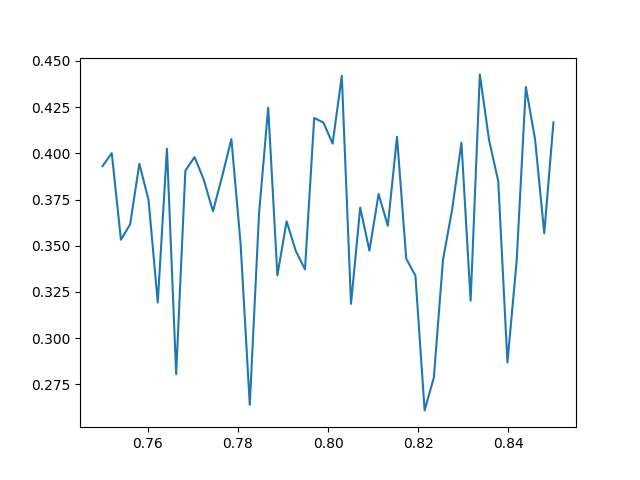

In [32]:
loss_val = [loss_num[-1] for loss_num in lvals]
plt.cla()
plt.plot(thetas,loss_val)
plt.savefig("aLund.png")
display(Image(filename="aLund.png"))